In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score,\
recall_score, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
analysis_df = pd.read_pickle('../pkl_files/analysis_df.pkl')
analysis_x = analysis_df.drop(['ponv', 'vomiting24h'], axis=1)
analysis_y = analysis_df['ponv']

In [3]:
# Extract Test Set
tv_x, test_x, tv_y, test_y = train_test_split(analysis_x, analysis_y, test_size=.2, random_state=10)
train_x, val_x, train_y, val_y = train_test_split(tv_x, tv_y, test_size=.25, random_state=444)

In [4]:
import log_reg_tuning as lrt
import Extract_feats_PONV as efp
import Oversample

In [5]:
# train-val set extract
tv_fin_x =  efp.extract_features(analysis_df, tv_x)
test_fin_x = efp.extract_features(analysis_df, test_x)

In [6]:
# # Testing based on train val - this is garbage
test_model = lrt.ponv_log_reg(tv_fin_x, tv_y)

Avg. f1 score: 0.49060999462438615
Avg. Roc/Auc score 0.6628837089521642


# Predict Test

In [7]:
# extract selected train and test features
os_tv_x, os_tv_y = Oversample.return_oversample(2, tv_fin_x, tv_y)
#scale features
train_input_sc, test_input_sc = lrt.std_scale(os_tv_x, test_fin_x)

In [8]:
#final_model = LogisticRegression(C=1000, class_weight={0 : 1, 1 : 2}, penalty='l1',
#                            solver='liblinear', tol=1e-6, max_iter=1000)
final_model = LogisticRegression(C=100, fit_intercept=False, solver='liblinear', tol=1e-06)
final_model.fit(train_input_sc, os_tv_y)

LogisticRegression(C=100, fit_intercept=False, solver='liblinear', tol=1e-06)

In [9]:
import pickle
pickle.dump(final_model, open('lr_final_model.p', 'wb'))

In [10]:
dict(zip(tv_fin_x.columns,final_model.coef_[0]))

{'gender_code': 0.3061267946437948,
 'non_smoker': 0.20684740944924315,
 'previous_ponv': 0.3436313421673297,
 'postoperative_opioids': 0.11600011941556439,
 'pancreatectomy': 0.14825075538391128,
 'hysterectomy_vlp': -0.008652117938347845,
 'anexectomy_ovariectomy': 0.02558250665703895,
 'cystectomy': 0.144732948527601,
 'extensive_lymphadenectomy': 0.017992995184003498,
 'plastic': -0.09218853966052303,
 'cytoreduction': -0.0022803982489848387,
 'hysterectomy': -0.05665833847764438,
 'nephrectomy': 0.07189551484129768,
 'mastectomy': -0.11618673063087556,
 'gastrointestinal': 0.05341099123294996,
 'thoracic': 0.008258570913280696,
 'exploratory_laparotomy': -0.053225520836680716,
 'hepatectomy': -0.09686997071333091,
 'prostatectomy': 0.01922121227663952,
 'breast_lumpectomy': -0.032103394221251004,
 'spine_surgery': -0.04652695045543955,
 'head_neck': -0.08371654480522876,
 'orthopedic': -0.244751618726024,
 'fentanil_mcg': 0.062428198723168425,
 'sufentanil_mcg': -0.111231367284901

# Predict on Test

In [11]:
final_soft = final_model.predict_proba(test_input_sc)
final_hard = (final_model.predict_proba(test_input_sc)[:,1] > .45)
final_cm = confusion_matrix(test_y, final_hard)

In [12]:
final_cm

array([[150, 115],
       [ 36,  76]])

In [13]:
print(f'ROC/AUC: {roc_auc_score(test_y, final_hard)}')
print(f'F1: {f1_score(test_y, final_hard)}')

ROC/AUC: 0.6223045822102425
F1: 0.5016501650165017


Logistic Regression Model best F1 score 0.674 at prob decision threshold >= 0.354


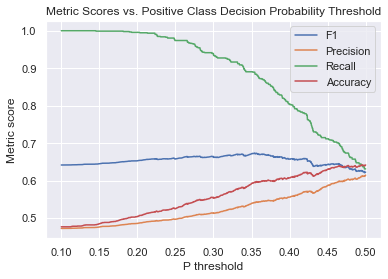

In [14]:
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = final_model.predict_proba(train_input_sc)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(os_tv_y, model_val_labels))    
    prec_scores.append(precision_score(os_tv_y, model_val_labels))
    rec_scores.append(recall_score(os_tv_y, model_val_labels))
    acc_scores.append(accuracy_score(os_tv_y, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

'solver':['liblinear', 'saga'],\
'penalty': ['l1', 'l2'],\
'tol': (1e-6, 100, 'log-uniform'),\
'C': (1e-6, 100, 'log-uniform'),\
'fit_intercept': [True, False]\
LogisticRegression(C=100, penalty='l1', solver='liblinear', tol=1e-06)

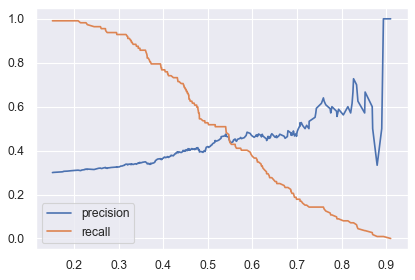

In [15]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(test_y, 
                                                                        final_model.predict_proba(test_input_sc)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend()

# GridSearchCV hypertuning

In [ ]:
# GridSearch for logreg
param_grid = {
    'solver':['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'tol': (1e-6, 100, 'log-uniform'),
    'C': (1e-6, 100, 'log-uniform'),
    'fit_intercept': [True, False]
}
clf = GridSearchCV(test_model, param_grid=param_grid, cv=10, scoring='roc_auc', verbose=True, n_jobs=-1)
best_clf = clf.fit(tv_fin_x, tv_y)

In [ ]:
best_clf.best_estimator_

# Apfel Output

In [27]:
import baseline_apfel as apfel

In [28]:
apfel_output = apfel.apfel_prob(test_x, test_y)

/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/Deployment/baseline_apfel.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apfel_output['apfel_prob'] = apfel_output['apfel'].map({0: .1, 1: .2, 2: .4, 3: .6, 4: .8})
/Users/paulchung/Dropbox (Personal)/Paul Working Folder/Home/Coding/Metis/github_backup/Project-3-Classifier/Deployment/baseline_apfel.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apfel_output['apfel_pred'] = apfel_output['apf

In [29]:
apfel_cm = confusion_matrix(apfel_output['actual'], apfel_output['apfel_pred'])
apfel_cm

array([[172,  93],
       [ 49,  63]])

In [30]:
f1_score(apfel_output['actual'], apfel_output['apfel_pred'])

0.47014925373134325

In [132]:
roc_auc_score(apfel_output['actual'], apfel_output['apfel_pred'])

0.6057783018867925

# Output Data for Visualizations

In [88]:
patientid = np.array(test_x['patientid'])

In [95]:
final_summary = pd.DataFrame([patientid,final_hard,final_soft[:,1]]).T

In [99]:
finaly_summary = final_summary.rename({0:'patientid',1:'hard_pred',2:'soft_pred'}, axis=1)

In [101]:
apfel_output.to_csv('../Viz/apfel_output.csv')
np.savetxt('../Viz/apfel_cm.csv', apfel_cm, delimiter=',')
final_summary.to_csv('../Viz/final_prob.csv', header=True)
np.savetxt('../Viz/final_cm.csv', final_cm, delimiter=',')

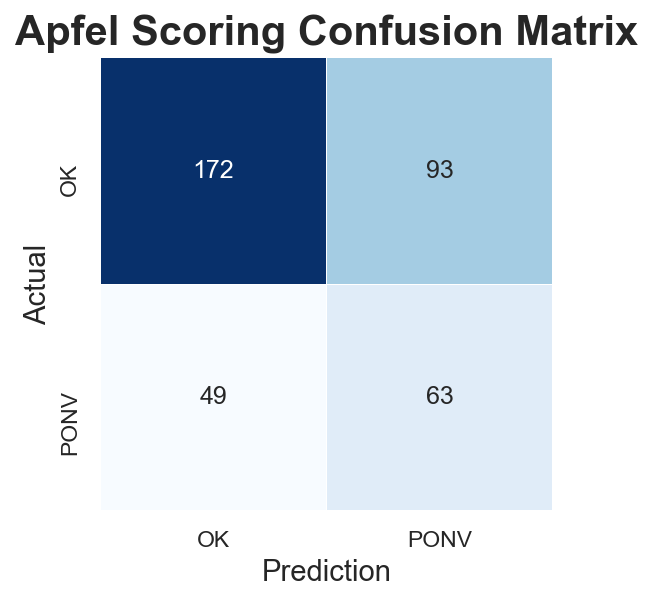

In [131]:
plt.figure(dpi=150)
plt.title('Apfel Scoring Confusion Matrix', fontsize=20, fontweight='bold')
sns.heatmap(apfel_cm, cmap=plt.cm.Blues, annot=True, square=True, 
            linewidths=0.1, fmt=".0f", cbar=False,
           xticklabels=['OK', 'PONV'],
           yticklabels=['OK', 'PONV'])
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.savefig('../Viz/Apfel_CM.png')

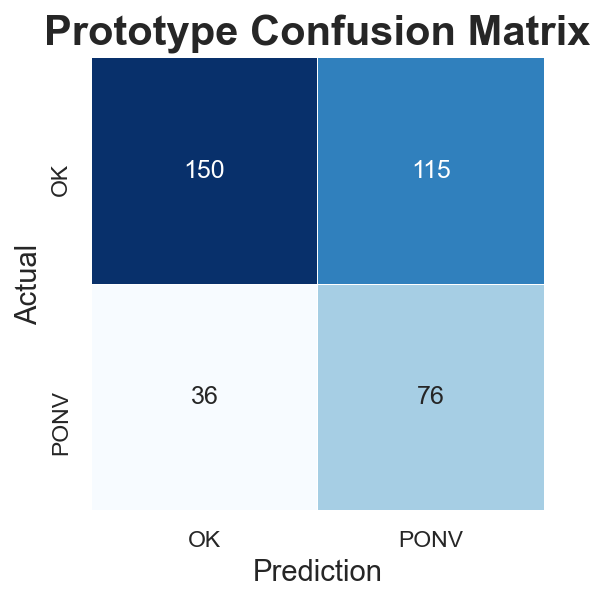

In [129]:
fig = plt.figure(dpi=150, facecolor='w', edgecolor='k')

plt.title('Prototype Confusion Matrix', fontsize=20, fontweight='bold')

fig = sns.heatmap(final_cm, cmap=plt.cm.Blues, annot=True, square=True, 
            linewidths=0.1, fmt=".0f", cbar=False,
           xticklabels=['OK', 'PONV'],
           yticklabels=['OK', 'PONV'])
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.savefig('../Viz/Final_CM.png')

# Streamlit App Test

In [21]:
tv_x.iloc[:10,:]

,patientid,age,apfel,previous_ponv,postoperative_opioids,non_smoker,surgery_group,chronic_opioid_user,previous_chemotherapy,how_many_months_ago_chemotherapy,...,esophagectomy,breast_lumpectomy,pancreatectomy,hip_arthoplasty,soft_tissue_resection,limb_amputation,gallbladder,gender_code,reg_ae_fillna,resc_ae_fillna
861,932,49,2,False,False,True,Gynaecological Surgery,False,False,0.0,...,0,0,0,0,0,0,0,1,True,False
1370,1487,37,3,False,True,True,Gastrointenstinal Surgery,False,True,36.0,...,0,0,0,0,0,0,0,1,True,True
946,1033,51,3,False,True,True,Breast surgery,False,True,1.0,...,0,0,0,0,0,0,0,1,False,False
697,743,64,2,False,False,True,Gastrointenstinal Surgery,False,False,0.0,...,0,0,0,0,0,0,0,1,False,True
1883,2014,47,3,False,True,True,Breast surgery,False,True,2.0,...,0,0,0,0,0,0,0,1,True,True
1830,1961,76,3,True,True,False,Gastrointenstinal Surgery,False,True,3.0,...,0,0,0,0,0,0,0,1,True,True
1156,1259,66,2,False,True,True,Ortopedic Surgery,True,False,0.0,...,0,0,0,0,0,0,0,0,False,True
1773,1903,21,3,True,True,False,Other,False,False,0.0,...,0,0,0,0,0,0,0,1,True,False
982,1073,65,3,False,True,True,Gastrointenstinal Surgery,False,False,0.0,...,0,0,0,0,0,0,0,1,True,False
1146,1247,56,3,False,True,True,Breast surgery,False,True,2.0,...,0,0,0,0,0,0,0,1,False,False


In [22]:
stlit_test = tv_x.iloc[[1]]
stlit_test

,patientid,age,apfel,previous_ponv,postoperative_opioids,non_smoker,surgery_group,chronic_opioid_user,previous_chemotherapy,how_many_months_ago_chemotherapy,...,esophagectomy,breast_lumpectomy,pancreatectomy,hip_arthoplasty,soft_tissue_resection,limb_amputation,gallbladder,gender_code,reg_ae_fillna,resc_ae_fillna
1370,1487,37,3,False,True,True,Gastrointenstinal Surgery,False,True,36.0,...,0,0,0,0,0,0,0,1,True,True


In [23]:
emetogenics = ['intraoperative_ondansetron_dose', 'dexamethasone_dose', 'intraoperative_dimenidrate_dose',
                   'metoclopramide_dose', 'droperidol_dose']
stlit_test.loc[1370,emetogenics]

intraoperative_ondansetron_dose    8
dexamethasone_dose                 4
intraoperative_dimenidrate_dose    0
metoclopramide_dose                0
droperidol_dose                    0
Name: 1370, dtype: object

In [24]:
stlit_x =  efp.extract_features(analysis_df, stlit_test)
dict(zip(stlit_x.columns, stlit_x.values[0]))

{'gender_code': 1,
 'non_smoker': True,
 'previous_ponv': False,
 'postoperative_opioids': True,
 'pancreatectomy': 0,
 'hysterectomy_vlp': 0,
 'anexectomy_ovariectomy': 0,
 'cystectomy': 0,
 'extensive_lymphadenectomy': 0,
 'plastic': 0,
 'cytoreduction': 0,
 'hysterectomy': 0,
 'nephrectomy': 0,
 'mastectomy': 0,
 'gastrointestinal': 1,
 'thoracic': 0,
 'exploratory_laparotomy': 0,
 'hepatectomy': 0,
 'prostatectomy': 0,
 'breast_lumpectomy': 0,
 'spine_surgery': 0,
 'head_neck': 0,
 'orthopedic': 0,
 'fentanil_mcg': 300.0,
 'sufentanil_mcg': 0.0,
 'tramadol_dose_pacu': 0.0,
 'ketamine_dose': 0.0,
 'intraoperative_morphine_dose': 0.0,
 'previous_chemotherapy': True,
 'how_many_months_ago_chemotherapy': 36.0,
 'post_chemotherapy_nausea': False,
 'post_chemotherapy_vomiting': False,
 'age': 37,
 'tot_drugs': 12.3}

In [143]:
scaler = pickle.load(open("ponv_scaler.p","rb"))
st_model = pickle.load(open("lr_final_model.p","rb"))
stlit_x_sc = scaler.transform(stlit_x)
st_model.predict_proba(stlit_x_sc)[:,1]

array([0.58833135])